In [17]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt

### Initial Conditions

In [102]:
S0 = 0.9
I0 = 1
R0 = 2.20

#beta = 0.3 # The parameter controlling how often a susceptible-infected contact results in a new infection.
#gamma = 0.1 # The rate an infected recovers and moves into the resistant phase.
#sigma = 0.1 # The rate at which an exposed person becomes infective.

D_incbation = 5.2 #Length of incubation period
D_infectious = 2.9 # Duration patient is infectious

InterventionTime = 100
OMInterventionAmt = 2/3
InterventionAmt = 1 - OMInterventionAmt

daysTotal = 220 # total days to model

days0 = 57  #days before lockdown measures

population = 7000000

E0 = 1  # exposed at initial time step

duration = 20


### SIR MODEL

In [103]:
  def model(y, t, N , s):
    # :param array t: Time step (days)
    # :param int N: Population
    # :param float beta: The parameter controlling how often a susceptible-infected contact results in a new infection.
    # :param float gamma: The rate an infected recovers and moves into the resistant phase.
    # :param float sigma: The rate at which an exposed person becomes infective.
    
    # Beta, Gamma and Sigma calculation
    if t > InterventionTime:
        beta = InterventionAmt * R0/ D_infectious
    else:
        beta = R0/D_infectious
      
    sigma = 1/D_incbation
    gamma = 1/D_infectious
    
    #print(beta)
    S, E, I, R = y

    #beta = beta0 if x < days0 else beta1
    
    dS = - beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    
    return ([dS, dE, dI, dR])
    

### SOLVE SIR MODEL

In [104]:
def solve(model, population, E0):
    X = np.arange(daysTotal)  # time steps array
    N0 = population - E0, E0, 0, 0  # S, E, I, R at initial step

    y_data_var = scipy.integrate.odeint(model, N0, X, args=(population,1))

    S, E, I, R = y_data_var.T  # transpose and unpack
    return X, S, E, I, R

In [105]:
X, S, E, I, R = solve(model, population, 1)

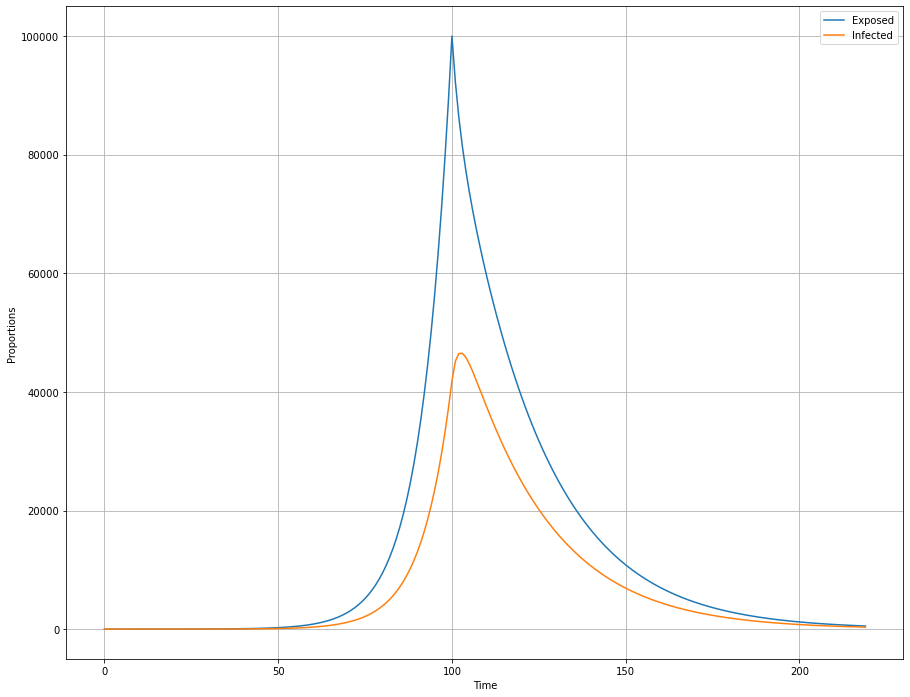

In [106]:
plt.figure(figsize=[15,12])
#plt.plot(X,S, label="Susceptible")
plt.plot(X,E, label="Exposed")
plt.plot(X,I, label="Infected")
#plt.plot(X,R, label="Recovered with immunity")

plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.show()